# Read Data

In [1]:
%matplotlib inline
import os
from copy import deepcopy

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tensorflow.contrib.opt import AdamWOptimizer

from data_manager import (
    DataManager,
)  # Note: you might need to install yaml via "pip install pyyaml"


def normalized_validation_score(true, predicted):
    # Normalize the area under the curve. A constant prediction will achieve an score of 0 whereas an oracle that predicts everything correct will have a score of 1.
    return roc_auc_score(true, predicted) * 2 - 1

def describe_categorical(x):
    """
    Similar to describe but uses object data
    """
    from IPython.display import display
    display(x[x.columns[x.dtypes == 'object']].describe())

dataset = "D"
input_dir = "./data/"
D_train = DataManager(
    dataset,
    input_dir,
    replace_missing=True,
    max_samples=np.inf,
    verbose=True,
    testdata=0,
    ltl=0,
)
D_valid = DataManager(
    dataset,
    input_dir,
    replace_missing=True,
    max_samples=np.inf,
    verbose=True,
    testdata=1,
    ltl=0,
)
D_test = DataManager(
    dataset,
    input_dir,
    replace_missing=True,
    max_samples=np.inf,
    verbose=True,
    testdata=2,
    ltl=0,
)
y_train0 = D_train.loadLabel(
    os.path.join(input_dir, "%s" % dataset, "%s_train1.solution" % dataset)
)

solutions_file_valid = os.path.join(
    input_dir, "%s" % dataset, "%s_test%d.solution" % (dataset, 1)
)
y_valid0 = np.loadtxt(solutions_file_valid)

numericals = D_train.data[0]["numerical"]
X_train0_categoricals = D_train.data[0]["CAT"]

# To make things easier we will for now only use the numerical features and ignore the categorical

X_train0 = numericals
# X_train = np.concatenate((numericals, categoricals), axis=1)

numericals = D_valid.data[0]["numerical"]
X_valid0_categoricals = D_valid.data[0]["CAT"]

X_valid0 = numericals
# X_valid = np.concatenate((numericals, categoricals), axis=1)

numericals = D_test.data[0]["numerical"]
X_test0_categoricals = D_test.data[0]["CAT"]

X_test0 = numericals
# X_test = np.concatenate((numericals, categoricals), axis=1)

print("================================================================================")
print("Reading data finished.")

C:\Users\MYPC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\MYPC\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Info file found : C:\Users\MYPC\DL_LAB\FinalProject\data\D\D_public.info
========= Reading ./data/D\D_feat.type
[+] Success in  0.00 sec
========= Reading ./data/D\D_feat.type
[+] Success in  0.00 sec
========= Reading ./data/D\D_train1.data
=== Detected 55 Numerical Features
=== Detected 17 Categorical Features
=== Detected 0 Multi-valued Categorical Features
=== Detected 4 Time Features
=== 153042 Samples will be loaded 
=== Processing 4 Time features 
=== Processing 55 Numerical features 
=== Processing 17 Categorical features 
Replace missing values by 0 (slow, sorry)
Loaded 153042 Samples and 59 Features
[+] Success in  8.87 sec
========= Reading ./data/D\D_train1.solution
Replace missing values by 0 (slow, sorry)
[+] Success in  0.37 sec
Info file found : C:\Users\MYPC\DL_LAB\FinalProject\data\D\D_public.info
========= Reading ./data/D\D_feat.type
[+] Success in  0.00 sec
========= Reading ./data/D\D_feat.type
[+] Success in  0.00 sec
========= Reading ./data/D\D_test1.data
=== D

# Shuffle training and validation data

In [2]:
X = np.concatenate((X_train0, X_valid0))
print(X)
y = deepcopy(np.concatenate((y_train0.reshape(-1), y_valid0)))
print(y)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=7)

y_cat = deepcopy(np.concatenate((y_train0.reshape(-1), y_valid0)))
X_categoricals = np.concatenate((X_train0_categoricals, X_valid0_categoricals))
X_train_categoricals, X_valid_categoricals, y_train_categoricals, y_valid_categoricals = train_test_split(X_categoricals, y_cat, test_size=0.3, random_state=7)

[[1.49374085e+09 1.46751662e+09 1.48253156e+09 ... 2.47500000e+02
  5.00000000e-01 0.00000000e+00]
 [1.49374086e+09 0.00000000e+00 0.00000000e+00 ... 5.00000000e-01
  5.00000000e-01 0.00000000e+00]
 [1.49374086e+09 0.00000000e+00 0.00000000e+00 ... 5.00000000e-01
  5.00000000e-01 0.00000000e+00]
 ...
 [1.49389398e+09 0.00000000e+00 0.00000000e+00 ... 5.00000000e-01
  5.00000000e-01 0.00000000e+00]
 [1.49391096e+09 1.47168616e+09 1.45329838e+09 ... 5.00000000e-01
  5.00000000e-01 0.00000000e+00]
 [1.49391276e+09 1.47938606e+09 0.00000000e+00 ... 5.00000000e-01
  5.00000000e-01 0.00000000e+00]]
[0. 0. 0. ... 0. 0. 0.]


# NaN -> Mean

In [3]:
X = {"name": "X", "TRAIN": deepcopy(X_train), "VALID": deepcopy(X_valid), "TEST": deepcopy(X_test0), "TRAIN_CAT": deepcopy(X_train_categoricals),"VALID_CAT": deepcopy(X_valid_categoricals)}

Y = {"name": "Y", "TRAIN": deepcopy(y_train), "VALID": deepcopy(y_valid),"TRAIN_CAT": deepcopy(y_train_categoricals), "VALID_CAT": deepcopy(y_valid_categoricals)}

for S in ["TRAIN", "VALID", "TEST"]:
    # to pandas DataFrame
    tmp = pd.DataFrame(X[S]).apply(pd.to_numeric, errors="coerce")
    # replace all NaN values with mean.
    X[S] = tmp.fillna(value=X[S].mean())
    #print(X["name"], S)
    #print(X[S])

# Normalization

In [4]:
for S in ["TRAIN", "VALID", "TEST"]:
    for c in X[S]:
        if X[S][c].std() != 0:
            X[S][c] = (X[S][c] - X[S][c].mean()) / X[S][c].std()
    #for c in X[S]:
    #    print(c, pd.isnull(X[S][c]).all())
    X[S] = X[S].values
    print(S, X[S].shape)

TRAIN (214316, 59)
VALID (91850, 59)
TEST (157852, 59)


# Training/Validation data class distribution

In [5]:
def data_dist(d, sets, **kwargs):
    print(d["name"])
    for s in sets:
        print(s)
        print(pd.value_counts(d[s], **kwargs))
    print()

data_dist(Y, ["TRAIN", "VALID"])
data_dist(Y, ["TRAIN", "VALID"], normalize=True)

Y
TRAIN
0.0    204017
1.0     10299
dtype: int64
VALID
0.0    87410
1.0     4440
dtype: int64

Y
TRAIN
0.0    0.951945
1.0    0.048055
dtype: float64
VALID
0.0    0.95166
1.0    0.04834
dtype: float64



# Downsampling class 0

In [6]:
df_train = pd.DataFrame(X["TRAIN"])
df_train_0 = df_train[Y["TRAIN"] == 0]
df_train_1 = df_train[Y["TRAIN"] == 1]

n_samples_train = 125000

# upsampling minority class
"""
df_train_1_upsampled = resample(df_train_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=n_samples_train,    # to match majority class
                                 random_state=123) 

X_trainC = pd.concat([df_train, df_train_1_upsampled]).values
y_train2 = np.ones(n_samples_train,dtype=int).reshape((-1,1))
y_trainC = pd.concat([pd.DataFrame(y_trainC),pd.DataFrame(y_train2)]).values
"""

# downsampling majority class
df_train_0_downsampled = resample(
    df_train_0,
    replace=False,  # sample with replacement
    n_samples=n_samples_train,  # to match majority class
    random_state=123,
)

X["TRAIN"] = pd.concat([df_train_1, df_train_0_downsampled]).values
Y["TRAIN"] = pd.concat(
    [
        pd.DataFrame(np.ones(df_train_1.shape[0], dtype=int).reshape((-1, 1))),
        pd.DataFrame(np.zeros(n_samples_train)),
    ]
).values.reshape(-1)

# Training/Validation data class distribution after downsampling

In [7]:
data_dist(Y, ["TRAIN", "VALID"], normalize=True)

Y
TRAIN
0.0    0.92388
1.0    0.07612
dtype: float64
VALID
0.0    0.95166
1.0    0.04834
dtype: float64



# Variance of Training/Validation data

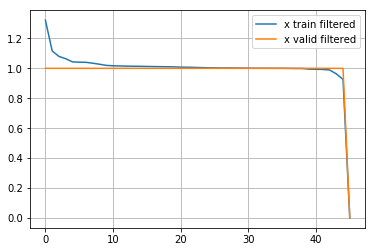

In [8]:
std = []
df = pd.DataFrame(X["TRAIN"])
dft = df.reindex(df.var().sort_values(ascending=False).index, axis=1)

dfv = pd.DataFrame(X["VALID"])
dftest = pd.DataFrame(X["TEST"])

X["TRAIN_FILTERED"] = df[dft.columns[0:46]].values
X["VALID_FILTERED"] = dfv[dft.columns[0:46]].values
pd.DataFrame(X["TRAIN_FILTERED"]).var().plot(label="x train filtered", legend=True, grid=True)
pd.DataFrame(X["VALID_FILTERED"]).var().plot(label="x valid filtered", legend=True, grid=True)

# Training

In [9]:
import hpbandster.core.nameserver as hpns
from hpbandster.optimizers import BOHB
from hpbandster.optimizers import RandomSearch

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from hpbandster.core.worker import Worker
import argparse
class MyWorker(Worker):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute(self, config, budget,**kwargs):
        """
        Evaluates the configuration on the defined budget and returns the validation performance.
        Args:
            config: dictionary containing the sampled configurations by the optimizer
            budget: (float) amount of time/epochs/etc. the model can use to train
        Returns:
            dictionary with mandatory fields:
                'loss' (scalar)
                'info' (dict)
        """
        lr = config["learning_rate"]
        batch_size = config["batch_size"]
        epochs = budget
        decay_rate = config["decay_rate"]

        # TODO: train and validate your convolutional neural networks here

        
        model = tf.keras.models.Sequential(
                                          [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
                           ]
                             )
        optim = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate)
            #bce = tf.keras.backend.binary_crossentropy(target, output, from_logits=True)

        model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics = ['accuracy', 'binary_crossentropy'])

        model.fit(X["TRAIN_FILTERED"], Y["TRAIN"], epochs=epochs, batch_size=batch_size)
        val_score = model.evaluate(X["VALID_FILTERED"], Y["VALID"])
        #validation_error=1-val_score[1]
        
        Y_HAT = model.predict(X["VALID_FILTERED"])
        auc=normalized_validation_score(Y["VALID"], Y_HAT)
        print("normalized_validation_score ", auc)
        validation_error= -auc
        

        # TODO: We minimize so make sure you return the validation error here
        return ({
            'loss': validation_error,  # this is the a mandatory field to run hyperband
            'info': {
                        'validation accuracy': val_score[1]
    
                
            }  # can be used for any user-defined information - also mandatory
        })
    @staticmethod
    def get_configspace():
        cs = CS.ConfigurationSpace()

        lr = CSH.UniformFloatHyperparameter('learning_rate', lower=0.0001, upper=0.1, default_value='0.1', log=True)
        decay_rate = CSH.UniformFloatHyperparameter('decay_rate', lower=0.0001, upper=0.1, default_value='0.001', log=True)
        batch_size = CSH.UniformIntegerHyperparameter('batch_size', lower=10000, upper=30000, default_value=20000, log=True)
        cs.add_hyperparameters([lr])
        cs.add_hyperparameters([decay_rate])
        cs.add_hyperparameters([batch_size])
        
        return cs

C:\Users\MYPC\Anaconda3\lib\site-packages\Pyro4\util.py:839: UserWarning: msgpack serializer unavailable. requires msgpack 0.5.2+, found (0, 5, 1)
  warnings.warn("msgpack serializer unavailable. requires msgpack 0.5.2+, found " + str(msgpack.version))


In [10]:
def train_incumbent(config,budget):
    model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ]
    )

    optim = AdamWOptimizer(
    weight_decay=config['decay_rate'], learning_rate=config['learning_rate'], beta1=0.9, beta2=0.999, epsilon=1e-08)

    model.compile(optimizer=optim,loss="binary_crossentropy",metrics=["accuracy", "binary_crossentropy"],)

    model.fit(X["TRAIN_FILTERED"], Y["TRAIN"], epochs=budget, batch_size=config['batch_size'], shuffle=True)
    return model

    

In [11]:
NS = hpns.NameServer(run_id='example1', host='127.0.0.1', port=None)
NS.start()

w = MyWorker(nameserver='127.0.0.1', run_id='example1')
w.run(background=True)

rs = RandomSearch(configspace=w.get_configspace(),
                  run_id='example1', nameserver='127.0.0.1',
                  min_budget=int(6), max_budget=int(6))
res = rs.run(n_iterations=10)

rs.shutdown(shutdown_workers=True)
NS.shutdown()

id2config = res.get_id2config_mapping()
incumbent = res.get_incumbent_id()

print('Best found configuration:', id2config[incumbent]['config'])

model = train_incumbent(config=id2config[incumbent]['config'],budget=6)

11:48:17 wait_for_workers trying to get the condition
11:48:17 DISPATCHER: started the 'discover_worker' thread
11:48:17 WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x19d060ee668; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:9090>
11:48:17 DISPATCHER: started the 'job_runner' thread
11:48:17 WORKER: No dispatcher found. Waiting for one to initiate contact.
11:48:17 WORKER: start listening for jobs
11:48:17 DISPATCHER: Pyro daemon running on localhost:62173
11:48:17 DISPATCHER: Starting worker discovery
11:48:17 DISPATCHER: Found 1 potential workers, 0 currently in the pool.
11:48:17 DISPATCHER: discovered new worker, hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832
11:48:17 HBMASTER: number of workers changed to 1
11:48:17 Enough workers to start this run!
11:48:17 adjust_queue_size: lock accquired
11:48:17 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:48:17 HBMASTER: starting run at 1548845297.7606313
11:48:17 HBMASTER: adjusted queue

Epoch 1/6
135299/135299 [==============================] - ETA: 0s - loss: 0.5426 - acc: 0.7524 - binary_crossentropy: 0.542 - 2s 12us/step - loss: 0.5383 - acc: 0.7560 - binary_crossentropy: 0.5383
Epoch 2/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.3034 - acc: 0.9239 - binary_crossentropy: 0.3034
Epoch 3/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2992 - acc: 0.9239 - binary_crossentropy: 0.2992
Epoch 4/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2780 - acc: 0.9239 - binary_crossentropy: 0.2780
Epoch 5/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2770 - acc: 0.9239 - binary_crossentropy: 0.2770
Epoch 6/6
91850/91850 [==============================] - 3s 35us/step


11:48:30 WORKER: done with job (0, 0, 0), trying to register it.
11:48:30 WORKER: registered result for job (0, 0, 0) with dispatcher
11:48:30 DISPATCHER: job (0, 0, 0) finished
11:48:30 DISPATCHER: register_result: lock acquired
11:48:30 DISPATCHER: job (0, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:48:30 job_id: (0, 0, 0)
kwargs: {'config': {'batch_size': 26500, 'decay_rate': 0.029490692981480177, 'learning_rate': 0.0028191856137346778}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.13839874681912212, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:48:30 job_callback for (0, 0, 0) started
11:48:30 DISPATCHER: Trying to submit another job.
11:48:30 job_callback for (0, 0, 0) got condition
11:48:30 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:48:30 HBMASTER: Trying to run another job!
11:48:30 job_callback for (0, 0, 0) finished
11:48:30 HBMASTER: schedule new run for iteration 1
11:48

normalized_validation_score  0.13839874681912212
Epoch 1/6
135299/135299 [==============================] - 1s 11us/step - loss: 0.2703 - acc: 0.9239 - binary_crossentropy: 0.2703
Epoch 2/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2694 - acc: 0.9239 - binary_crossentropy: 0.2694
Epoch 3/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2681 - acc: 0.9239 - binary_crossentropy: 0.2681
Epoch 4/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2672 - acc: 0.9239 - binary_crossentropy: 0.2672
Epoch 5/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2667 - acc: 0.9239 - binary_crossentropy: 0.2667
Epoch 6/6
91850/91850 [==============================] - 3s 34us/step


11:48:42 WORKER: done with job (1, 0, 0), trying to register it.
11:48:42 WORKER: registered result for job (1, 0, 0) with dispatcher
11:48:42 DISPATCHER: job (1, 0, 0) finished
11:48:42 DISPATCHER: register_result: lock acquired
11:48:42 DISPATCHER: job (1, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:48:42 job_id: (1, 0, 0)
kwargs: {'config': {'batch_size': 27868, 'decay_rate': 0.00013216510518612894, 'learning_rate': 0.0013636326354879305}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.19276204301773459, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:48:42 job_callback for (1, 0, 0) started
11:48:42 DISPATCHER: Trying to submit another job.
11:48:42 job_callback for (1, 0, 0) got condition
11:48:42 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:48:42 HBMASTER: Trying to run another job!
11:48:42 job_callback for (1, 0, 0) finished
11:48:42 HBMASTER: schedule new run for iteration 2
11:

normalized_validation_score  0.19276204301773459
Epoch 1/6
135299/135299 [==============================] - 2s 11us/step - loss: 0.2655 - acc: 0.9239 - binary_crossentropy: 0.2655
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2647 - acc: 0.9239 - binary_crossentropy: 0.2647
Epoch 3/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2641 - acc: 0.9239 - binary_crossentropy: 0.2641
Epoch 4/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2636 - acc: 0.9239 - binary_crossentropy: 0.2636
Epoch 5/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2631 - acc: 0.9239 - binary_crossentropy: 0.2631
Epoch 6/6
91850/91850 [==============================] - 3s 37us/step


11:48:55 WORKER: done with job (2, 0, 0), trying to register it.
11:48:55 WORKER: registered result for job (2, 0, 0) with dispatcher
11:48:55 DISPATCHER: job (2, 0, 0) finished
11:48:56 DISPATCHER: register_result: lock acquired
11:48:56 DISPATCHER: job (2, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:48:56 job_id: (2, 0, 0)
kwargs: {'config': {'batch_size': 10647, 'decay_rate': 0.007257522669159854, 'learning_rate': 0.0006899334801682543}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.22214790554196795, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:48:56 job_callback for (2, 0, 0) started
11:48:56 DISPATCHER: Trying to submit another job.
11:48:56 job_callback for (2, 0, 0) got condition
11:48:56 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:48:56 HBMASTER: Trying to run another job!
11:48:56 job_callback for (2, 0, 0) finished
11:48:56 HBMASTER: schedule new run for iteration 3
11:48

normalized_validation_score  0.22214790554196795
Epoch 1/6
135299/135299 [==============================] - 2s 11us/step - loss: 0.2625 - acc: 0.9239 - binary_crossentropy: 0.2625
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2623 - acc: 0.9239 - binary_crossentropy: 0.2623
Epoch 3/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2622 - acc: 0.9239 - binary_crossentropy: 0.2622
Epoch 4/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2621 - acc: 0.9239 - binary_crossentropy: 0.2621
Epoch 5/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2619 - acc: 0.9239 - binary_crossentropy: 0.2619
Epoch 6/6
91850/91850 [==============================] - 3s 36us/step


11:49:08 WORKER: done with job (3, 0, 0), trying to register it.
11:49:08 WORKER: registered result for job (3, 0, 0) with dispatcher
11:49:08 DISPATCHER: job (3, 0, 0) finished
11:49:09 DISPATCHER: register_result: lock acquired
11:49:09 DISPATCHER: job (3, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:49:09 job_id: (3, 0, 0)
kwargs: {'config': {'batch_size': 23929, 'decay_rate': 0.0003360538469368812, 'learning_rate': 0.06329899528142081}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.2290683055209426, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:49:09 job_callback for (3, 0, 0) started
11:49:09 DISPATCHER: Trying to submit another job.
11:49:09 job_callback for (3, 0, 0) got condition
11:49:09 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:49:09 HBMASTER: Trying to run another job!
11:49:09 job_callback for (3, 0, 0) finished
11:49:09 HBMASTER: schedule new run for iteration 4
11:49:0

normalized_validation_score  0.2290683055209426
Epoch 1/6
135299/135299 [==============================] - 1s 11us/step - loss: 0.2617 - acc: 0.9239 - binary_crossentropy: 0.2617
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2616 - acc: 0.9239 - binary_crossentropy: 0.2616
Epoch 3/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2615 - acc: 0.9239 - binary_crossentropy: 0.2615
Epoch 4/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2614 - acc: 0.9239 - binary_crossentropy: 0.2614
Epoch 5/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2613 - acc: 0.9239 - binary_crossentropy: 0.2613
Epoch 6/6
38304/91850 [===========>..................] - ETA: 2s

11:49:17 DISPATCHER: Starting worker discovery
11:49:17 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
11:49:17 DISPATCHER: Finished worker discovery


91850/91850 [==============================] - 3s 38us/step


11:49:21 WORKER: done with job (4, 0, 0), trying to register it.
11:49:21 WORKER: registered result for job (4, 0, 0) with dispatcher
11:49:21 DISPATCHER: job (4, 0, 0) finished
11:49:21 DISPATCHER: register_result: lock acquired
11:49:21 DISPATCHER: job (4, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:49:21 job_id: (4, 0, 0)
kwargs: {'config': {'batch_size': 24694, 'decay_rate': 0.00029439952497866903, 'learning_rate': 0.003420350661316098}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.23452608397208552, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:49:21 job_callback for (4, 0, 0) started
11:49:21 DISPATCHER: Trying to submit another job.
11:49:21 job_callback for (4, 0, 0) got condition
11:49:21 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:49:21 HBMASTER: Trying to run another job!
11:49:21 job_callback for (4, 0, 0) finished
11:49:21 HBMASTER: schedule new run for iteration 5
11:4

normalized_validation_score  0.23452608397208552
Epoch 1/6
135299/135299 [==============================] - 1s 11us/step - loss: 0.2611 - acc: 0.9239 - binary_crossentropy: 0.2611
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2609 - acc: 0.9239 - binary_crossentropy: 0.2609
Epoch 3/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2608 - acc: 0.9239 - binary_crossentropy: 0.2608
Epoch 4/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2607 - acc: 0.9239 - binary_crossentropy: 0.2607
Epoch 5/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2605 - acc: 0.9239 - binary_crossentropy: 0.2605
Epoch 6/6
91850/91850 [==============================] - 3s 37us/step


11:49:35 WORKER: done with job (5, 0, 0), trying to register it.
11:49:35 WORKER: registered result for job (5, 0, 0) with dispatcher
11:49:35 DISPATCHER: job (5, 0, 0) finished
11:49:35 DISPATCHER: register_result: lock acquired
11:49:35 DISPATCHER: job (5, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:49:35 job_id: (5, 0, 0)
kwargs: {'config': {'batch_size': 15789, 'decay_rate': 0.0021475124451223316, 'learning_rate': 0.01246202815189295}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.24022568129277877, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:49:35 job_callback for (5, 0, 0) started
11:49:35 DISPATCHER: Trying to submit another job.
11:49:35 job_callback for (5, 0, 0) got condition
11:49:35 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:49:35 HBMASTER: Trying to run another job!
11:49:35 job_callback for (5, 0, 0) finished
11:49:35 HBMASTER: schedule new run for iteration 6
11:49:

normalized_validation_score  0.24022568129277877
Epoch 1/6
135299/135299 [==============================] - 2s 13us/step - loss: 0.2603 - acc: 0.9239 - binary_crossentropy: 0.2603
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2602 - acc: 0.9239 - binary_crossentropy: 0.2602
Epoch 3/6
135299/135299 [==============================] - 1s 8us/step - loss: 0.2602 - acc: 0.9239 - binary_crossentropy: 0.2602
Epoch 4/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2601 - acc: 0.9239 - binary_crossentropy: 0.2601
Epoch 5/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2600 - acc: 0.9239 - binary_crossentropy: 0.2600
Epoch 6/6
91850/91850 [==============================] - 3s 36us/step


11:49:48 WORKER: done with job (6, 0, 0), trying to register it.
11:49:48 WORKER: registered result for job (6, 0, 0) with dispatcher
11:49:48 DISPATCHER: job (6, 0, 0) finished
11:49:48 DISPATCHER: register_result: lock acquired
11:49:48 DISPATCHER: job (6, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:49:48 job_id: (6, 0, 0)
kwargs: {'config': {'batch_size': 23616, 'decay_rate': 0.004580481248839686, 'learning_rate': 0.00505021889661801}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.2438492462259767, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:49:48 job_callback for (6, 0, 0) started
11:49:48 DISPATCHER: Trying to submit another job.
11:49:48 job_callback for (6, 0, 0) got condition
11:49:48 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:49:48 HBMASTER: Trying to run another job!
11:49:48 job_callback for (6, 0, 0) finished
11:49:48 HBMASTER: schedule new run for iteration 7
11:49:48

normalized_validation_score  0.2438492462259767
Epoch 1/6
135299/135299 [==============================] - 2s 11us/step - loss: 0.2599 - acc: 0.9239 - binary_crossentropy: 0.2599
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2599 - acc: 0.9239 - binary_crossentropy: 0.2599
Epoch 3/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2598 - acc: 0.9239 - binary_crossentropy: 0.2598
Epoch 4/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2598 - acc: 0.9239 - binary_crossentropy: 0.2598
Epoch 5/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2597 - acc: 0.9239 - binary_crossentropy: 0.2597
Epoch 6/6
91850/91850 [==============================] - 3s 36us/step


11:50:01 WORKER: done with job (7, 0, 0), trying to register it.
11:50:01 WORKER: registered result for job (7, 0, 0) with dispatcher
11:50:01 DISPATCHER: job (7, 0, 0) finished
11:50:01 DISPATCHER: register_result: lock acquired
11:50:01 DISPATCHER: job (7, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:50:01 job_id: (7, 0, 0)
kwargs: {'config': {'batch_size': 29337, 'decay_rate': 0.012618776970541236, 'learning_rate': 0.00010758850935051268}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.24605762838688117, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:50:01 job_callback for (7, 0, 0) started
11:50:01 job_callback for (7, 0, 0) got condition
11:50:01 DISPATCHER: Trying to submit another job.
11:50:01 HBMASTER: Trying to run another job!
11:50:01 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:50:01 job_callback for (7, 0, 0) finished
11:50:01 HBMASTER: schedule new run for iteration 8
11:5

normalized_validation_score  0.24605762838688117
Epoch 1/6
135299/135299 [==============================] - 2s 11us/step - loss: 0.2596 - acc: 0.9239 - binary_crossentropy: 0.2596
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2595 - acc: 0.9239 - binary_crossentropy: 0.2595
Epoch 3/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2594 - acc: 0.9239 - binary_crossentropy: 0.2594
Epoch 4/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2593 - acc: 0.9239 - binary_crossentropy: 0.2593
Epoch 5/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2592 - acc: 0.9239 - binary_crossentropy: 0.2592
Epoch 6/6
91850/91850 [==============================] - 3s 37us/step


11:50:14 WORKER: done with job (8, 0, 0), trying to register it.
11:50:14 WORKER: registered result for job (8, 0, 0) with dispatcher
11:50:14 DISPATCHER: job (8, 0, 0) finished
11:50:14 DISPATCHER: register_result: lock acquired
11:50:14 DISPATCHER: job (8, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:50:14 job_id: (8, 0, 0)
kwargs: {'config': {'batch_size': 11219, 'decay_rate': 0.006705644403166464, 'learning_rate': 0.00043069286567656064}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.25042555740731, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:50:14 job_callback for (8, 0, 0) started
11:50:14 DISPATCHER: Trying to submit another job.
11:50:14 job_callback for (8, 0, 0) got condition
11:50:14 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:50:14 HBMASTER: Trying to run another job!
11:50:14 job_callback for (8, 0, 0) finished
11:50:14 HBMASTER: schedule new run for iteration 9
11:50:1

normalized_validation_score  0.25042555740731
Epoch 1/6
112224/135299 [=======================>......] - ETA: 0s - loss: 0.2579 - acc: 0.9244 - binary_crossentropy: 0.2579

11:50:17 DISPATCHER: Starting worker discovery
11:50:17 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
11:50:17 DISPATCHER: Finished worker discovery


135299/135299 [==============================] - 1s 11us/step - loss: 0.2591 - acc: 0.9239 - binary_crossentropy: 0.2591
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2590 - acc: 0.9239 - binary_crossentropy: 0.2590
Epoch 3/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2589 - acc: 0.9239 - binary_crossentropy: 0.2589
Epoch 4/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2588 - acc: 0.9239 - binary_crossentropy: 0.2588
Epoch 5/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2588 - acc: 0.9239 - binary_crossentropy: 0.2588
Epoch 6/6
91850/91850 [==============================] - 3s 31us/step


11:50:27 WORKER: done with job (9, 0, 0), trying to register it.
11:50:27 WORKER: registered result for job (9, 0, 0) with dispatcher
11:50:27 DISPATCHER: job (9, 0, 0) finished
11:50:27 DISPATCHER: register_result: lock acquired
11:50:27 DISPATCHER: job (9, 0, 0) on hpbandster.run_example1.worker.DESKTOP-HNPU7LV.756022832 finished
11:50:27 job_id: (9, 0, 0)
kwargs: {'config': {'batch_size': 16032, 'decay_rate': 0.000509315269448498, 'learning_rate': 0.06939427967464006}, 'budget': 6, 'working_directory': '.'}
result: {'loss': -0.2530328054286983, 'info': {'validation accuracy': 0.9516603157295763}}
exception: None

11:50:27 job_callback for (9, 0, 0) started
11:50:27 DISPATCHER: Trying to submit another job.
11:50:27 job_callback for (9, 0, 0) got condition
11:50:27 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:50:27 HBMASTER: Trying to run another job!
11:50:27 job_callback for (9, 0, 0) finished
11:50:27 HBMASTER: shutdown initiated, shutdown_workers = Tr

normalized_validation_score  0.2530328054286983


11:50:27 DISPATCHER: Dispatcher shutting down
11:50:27 DISPATCHER: Trying to submit another job.
11:50:27 DISPATCHER: job_runner shutting down
11:50:27 DISPATCHER: discover_workers shutting down
11:50:27 DISPATCHER: 'discover_worker' thread exited
11:50:27 DISPATCHER: 'job_runner' thread exited
11:50:27 DISPATCHER: shut down complete


Best found configuration: {'batch_size': 16032, 'decay_rate': 0.000509315269448498, 'learning_rate': 0.06939427967464006}
Epoch 1/6
135299/135299 [==============================] - 2s 11us/step - loss: 0.2587 - acc: 0.9239 - binary_crossentropy: 0.2587
Epoch 2/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2586 - acc: 0.9239 - binary_crossentropy: 0.2586
Epoch 3/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2585 - acc: 0.9239 - binary_crossentropy: 0.2585
Epoch 4/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2585 - acc: 0.9239 - binary_crossentropy: 0.2585
Epoch 5/6
135299/135299 [==============================] - 1s 6us/step - loss: 0.2585 - acc: 0.9239 - binary_crossentropy: 0.2585
Epoch 6/6
135299/135299 [==============================] - 1s 7us/step - loss: 0.2584 - acc: 0.9239 - binary_crossentropy: 0.2584


In [12]:
''''model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=(59,)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ]
)

# optim = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
optim = AdamWOptimizer(
    weight_decay=0.001, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-08
)
# bce = tf.keras.backend.binary_crossentropy(target, output, from_logits=True)

model.compile(
    optimizer=optim,
    loss="binary_crossentropy",
    metrics=["accuracy", "binary_crossentropy"],
)

model.fit(X["TRAIN_FILTERED"], Y["TRAIN"], epochs=40, batch_size=20000, shuffle=True)'''




'\'model = tf.keras.models.Sequential(\n    [\n        tf.keras.layers.Flatten(),\n        tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(59,)),\n        tf.keras.layers.Dropout(0.2),\n        tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(59,)),\n        tf.keras.layers.Dropout(0.3),\n        tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=(59,)),\n        tf.keras.layers.Dropout(0.4),\n        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),\n    ]\n)\n\n# optim = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)\noptim = AdamWOptimizer(\n    weight_decay=0.001, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-08\n)\n# bce = tf.keras.backend.binary_crossentropy(target, output, from_logits=True)\n\nmodel.compile(\n    optimizer=optim,\n    loss="binary_crossentropy",\n    metrics=["accuracy", "binary_crossentropy"],\n)\n\nmodel.fit(X["TRAIN_FILTERED"], Y["TRAIN"], epochs=40, batch_s

# Evaluation of Numerical Features

In [13]:
res = model.evaluate(X["VALID_FILTERED"], Y["VALID"])
for i, m in enumerate(model.metrics_names):
    print(m, res[i])

Y_HAT = model.predict(X["VALID_FILTERED"])
print("normalized_validation_score ", normalized_validation_score(Y["VALID"], Y_HAT))

91850/91850 [==============================] - 3s 34us/step
loss 0.19511235330892635
acc 0.9516494284132997
binary_crossentropy 0.19511235330892635
normalized_validation_score  0.25532134210632096


# Description of Categorical Features

In [14]:
df_train = pd.DataFrame(X["TRAIN_CAT"])
df_valid = pd.DataFrame(X["VALID_CAT"])

print(df_train.columns.values)
print(df_valid.columns.values)

describe_categorical(df_train)
describe_categorical(df_valid)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,214316,214316,214316,214316,214316,127002,127006,80134,127002,214316,214316,134022,134015,73744,134022,214316,214316
unique,14244,8358,48347,214313,2,541,527,343,121,4,3,828,703,365,192,31,1
top,2985445252451961379,14475392532262432119,15072482018280671789,7713461017225751774,14771401151246747869,7638001807695707609,6220772307398391706,13871198517152104089,5656685945142785391,6843963171864976598,14771401151246747869,7265916326799606203,6220772307398391706,13871198517152104089,5656685945142785391,6843963171864976598,6843963171864976598
freq,676,1078,132,2,111046,11062,5112,5199,50225,181605,189566,9303,5948,3531,27790,162816,214316


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,91850,91850,91850,91850,91850,54419,54419,34414,54419,91850,91850,57526,57524,31771,57526,91850,91850
unique,11621,7033,34603,91850,3,509,513,333,110,4,3,773,639,356,176,30,1
top,3279021083640072691,14475392532262432119,15072482018280671789,16665491600719736855,14771401151246747869,7638001807695707609,6220772307398391706,13871198517152104089,5656685945142785391,6843963171864976598,14771401151246747869,7265916326799606203,6220772307398391706,13871198517152104089,5656685945142785391,6843963171864976598,6843963171864976598
freq,286,449,59,1,47588,4807,2200,2260,21561,77780,81180,4049,2681,1535,11887,69593,91850


# Droping Unimportant Categorical Features and Handling Missing Values

In [15]:
df_train.drop([4,7,8,9,10,13,14,15,16],axis=1,inplace=True)
df_valid.drop([4,7,8,9,10,13,14,15,16],axis=1,inplace=True)

for var in df_train:
    df_train[var].fillna(0, inplace=True)

for var in df_valid:
    df_valid[var].fillna(0, inplace=True)

# Fitting Random Forest to Categorical Features

In [16]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(df_train.values, Y["TRAIN_CAT"])
pred_valid = rf.predict(df_valid.values)
#print(pred_valid)


In [17]:
from sklearn.ensemble import BaggingRegressor
rf = BaggingRegressor(n_estimators = 300, random_state = 42)
rf.fit(df_train.values, Y["TRAIN_CAT"])
pred_valid = rf.predict(df_valid.values)

# Categorical Feature Importances

In [21]:
''''features_list = df_train.columns.values
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)[:20]

plt.figure(figsize=(5,7))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()'''

"'features_list = df_train.columns.values\nfeature_importance = rf.feature_importances_\nsorted_idx = np.argsort(feature_importance)[:20]\n\nplt.figure(figsize=(5,7))\nplt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')\nplt.yticks(range(len(sorted_idx)), features_list[sorted_idx])\nplt.xlabel('Importance')\nplt.title('Feature importances')\nplt.draw()\nplt.show()"

# Evaluation of Categorical Data

In [19]:
normalized_validation_score(Y["VALID_CAT"],pred_valid)

0.30691067053782994

# Combined Evaluation of Feed Forward Neural Network and Random Forest 

In [ ]:
y_pred_combined = (pred_valid.reshape(-1,1)+ Y_HAT.reshape(-1,1))/2
normalized_validation_score(Y["VALID"],y_pred_combined)